In [167]:
%matplotlib inline
from IPython.display import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from numpy.random import seed
import matplotlib.pyplot as plt
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from lib import *
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

In [168]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])
                                   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('#Training data points: {}'.format(X_train.shape[0]))
print('#Testing data points: {}'.format(X_test.shape[0]))
print('Class labels: {} (mapped from {}'.format(np.unique(y), np.unique(df['Class label'])))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 80
#Testing data points: 20
Class labels: [-1  1] (mapped from ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [169]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [170]:
class AdalineSGD_2(object):
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1, mibah=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        self.mibah=mibah        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi in range(0,X.shape[0],self.mibah):
                cost.append(self._update_weights(X[xi:xi+self.mibah], y[xi:xi+self.mibah]))
            avg_cost = sum(cost) / (len(y) / self.mibah)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        output = self.activation(xi)
        error = (target - output) / output.shape[0] 
        self.w_[1:] += self.eta * xi.T.dot(error)
        self.w_[0] += self.eta * error.sum()
        cost = 0.5 * ((error*output.shape[0])**2).sum() / output.shape[0] 
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return self.net_input(X)

    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

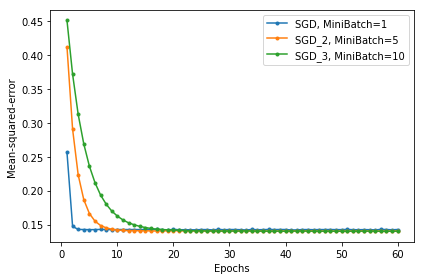

MiniBatch: 1
Misclassified samples: 1
Accuracy: 0.95
MiniBatch: 5
Misclassified samples: 1
Accuracy: 0.95
MiniBatch: 10
Misclassified samples: 1
Accuracy: 0.95


In [171]:
adas = AdalineSGD_2(n_iter=60, eta=0.01, random_state=1, mibah=1)
adas.fit(X_train_std, y_train)
adas_2 = AdalineSGD_2(n_iter=60, eta=0.01, random_state=1, mibah=5)
adas_2.fit(X_train_std, y_train)
adas_3 = AdalineSGD_2(n_iter=60, eta=0.01, random_state=1, mibah=10)
adas_3.fit(X_train_std, y_train)
# cost values

plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, 
         marker='.', label='SGD, MiniBatch=%d' % adas.mibah)
plt.plot(range(1, len(adas_2.cost_) + 1), adas_2.cost_, 
         marker='.', label='SGD_2, MiniBatch=%d' % adas_2.mibah)
plt.plot(range(1, len(adas_3.cost_) + 1), adas_3.cost_, 
         marker='.', label='SGD_3, MiniBatch=%d' % adas_3.mibah)
plt.xlabel('Epochs')
plt.ylabel('Mean-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('Lab04-1_107065511.png', dpi=300)
plt.show()

# testing accuracy

y_pred = adas.predict(X_test_std)
print('MiniBatch: %d' % adas.mibah)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
y_pred = adas_2.predict(X_test_std)
print('MiniBatch: %d' % adas_2.mibah)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
y_pred = adas_3.predict(X_test_std)
print('MiniBatch: %d' % adas_3.mibah)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))